In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from os.path import join
from PIL import Image
from os.path import join
import numpy
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

In [10]:
%reload_ext autoreload
%autoreload 2
%autosave 120
%matplotlib inline
# import keras
import numpy as np, matplotlib.pyplot as plt
from os.path import join


Autosaving every 120 seconds


In [11]:
def load_tfl_data(data_dir, crop_shape=(81, 81)):
    images = np.memmap(join(data_dir, 'data.bin'), mode='r', dtype=np.uint8).reshape([-1] + list(crop_shape) + [3])
    labels = np.memmap(join(data_dir, 'label.bin'), mode='r', dtype=np.uint8)
    return {'images': images, 'labels': labels}

In [12]:
def viz_my_data(images,labels, predictions=None, num=(5,5), labels2name= {0:'No TFL',1:'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h= 5
    n = num[0]*num[1]
    ax = plt.subplots(num[0],num[1],figsize=(h*num[0],h*num[1]),gridspec_kw={'wspace':0.05},squeeze=False,sharex=True,sharey=True)[1]#.flatten()
    idxs = np.random.randint(0,images.shape[0],n)
    for i,idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None : title += ' Prediction: {}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)

data_dir = './data_dir/'
#

In [13]:
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
for k,v in datasets.items():
    
    print ('{} :  {} 0/1 split {:.1f} %'.format(k,v['images'].shape, np.mean(v['labels']==1)*100))

viz_my_data(num=(7,7),**datasets['train'])


FileNotFoundError: [Errno 2] No such file or directory: './data_dir/val\\label.bin'

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation,MaxPooling2D,BatchNormalization,Activation, Conv2D

In [139]:
def tfl_model():
    input_shape =(81,81,3)
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def dense_bn_relu(units):
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        #conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32)     
    spatial_layer(3,64)
    spatial_layer(3,64) 
    model.add(Flatten())
    dense_bn_relu(96)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()
m.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 79, 79, 32)        864       
_________________________________________________________________
batch_normalization_70 (Batc (None, 79, 79, 32)        128       
_________________________________________________________________
activation_70 (Activation)   (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 77, 77, 32)        9216      
_________________________________________________________________
batch_normalization_71 (Batc (None, 77, 77, 32)        128       
_________________________________________________________________
activation_71 (Activation)   (None, 77, 77, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 75, 75, 64)       

In [141]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
#data_dir = '/tmp/scaleup/'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }  #maybe data_dir instead of root
#prepare our model
m = tfl_model()
m.compile(optimizer=Adam(),loss =sparse_categorical_crossentropy,metrics=['accuracy'])
train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']),epochs = 15)

ValueError: operands could not be broadcast together with shapes (582,81,81,3) (36,81,81,3) 

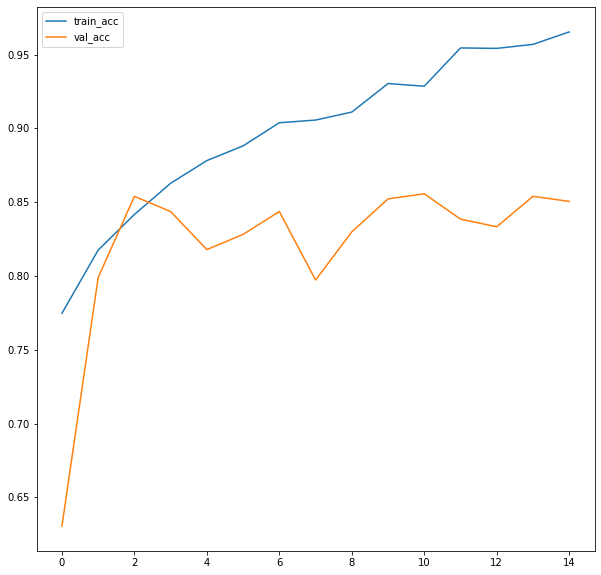

In [21]:
epochs = history.history
epochs['train_acc'] = epochs['acc']
plt.figure(figsize=(10,10))
for k in ['train_acc','val_acc']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)
plt.legend();

accuracy: 0.8178694158075601


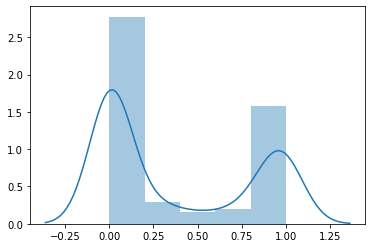

In [99]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);
predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

In [22]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

NameError: name 'predictions' is not defined

In [58]:
m.save("model.h5")